# Neonatal brain measure estimation from dHCP data
As dHCP is under data protection, no data is included in this repository. The code is provided as a reference for the analysis of the dHCP data. To reproduce the analyses, you need to apply for access to the dHCP dataset [here](https://nda.nih.gov/edit_collection.html?id=3955), and parcellate the data with the [MCRIBS atlas](https://github.com/DevelopmentalImagingMCRI/MCRIBS). Change the directory `mcribs_data_dir` accordingly. Data can be requested from the authors among reasonable request.

I received parcellated data from my collaborators C. Adamson, G. Ball, and J. Seidlitz.

This whole notebook should be run for cortical thickness (CT) or surface area (SA). Both measures were used in the original publication. Adjust the variable `brain_measure` to `CT` or `SA` accordingly. 

In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load MRI related data
## Rearrange individual files
The output generated by MCRIBS is similar to FreeSurfer's ?.aparc.annot files. First, I have rearranged them as aparcstats2table would do (i.e., generate one file containing all subjects' brain_measure information).
For measures of cerebral tissue volume, I have actually used asegstats2table, a FreeSurfer command. If you want to do so too, please make sure that FreeSurfer is installed on your machine and that the environment variable `FREESURFER_HOME` is correctly set (see [here](https://surfer.nmr.mgh.harvard.edu/fswiki/DownloadAndInstall)). Otherwise, just load the combined `aseg` file below.

In [26]:
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import subprocess
from abagen import fetch_desikan_killiany

import sys
sys.path.append('code')
from preprocessing import dhcp_aparcstats2table, strip_dhcp_id
from utils import read_dhcp_meta, reorder_vars


dhcp_data_dir = 'data/dHCP'
mcribs_data_dir = 'data/dHCP/rel2/dhcp-MCRIBS'  # where MCRIBS parcellated data are saved
dhcp_data_dir_rel = 'data/dHCP/rel2'  # where the dHCP data are saved

dhcp_freesurfer_outputs = join(dhcp_data_dir, 'freesurfer')  # where all freesurfer outputs are stored
dhcp_out = join(dhcp_data_dir, 'derivatives')  # where the adapted data will be stored
os.makedirs(dhcp_out, exist_ok=True)


# adjust brain measurement for which the code should be run
brain_measure = 'SA'  # CT or SA

In [27]:
# lh
csv_files = glob.glob(mcribs_data_dir + "/*lh.aparc.stats")  # find all files with left hemisphere data
aparc_lh = dhcp_aparcstats2table(csv_files, brain_measure)

# rh
csv_files = glob.glob(mcribs_data_dir + "/*rh.aparc.stats")
aparc_rh = dhcp_aparcstats2table(csv_files, brain_measure)

mri_data = pd.concat([aparc_lh, aparc_rh], axis=1)
mri_data.index.name = 'participant'
mri_data.columns.name = ''

# separate session and participant id
mri_data = strip_dhcp_id(mri_data)

# get region names of the Desikan-Killiany atlas as now used in the dHCP data
dhcp_idps_idx = mri_data.filter(regex='^ctx-').columns

In [28]:
# access DK atlas and save idp_labels
atlas = fetch_desikan_killiany(surface=True)
atlas = pd.read_csv(atlas['info'])
atlas = atlas[(atlas['structure'] == 'cortex') & (atlas['hemisphere'] == 'L')]
atlas_labels_l = ['L_'+label for label in atlas['label']]
atlas_labels_r = ['R_'+label for label in atlas['label']]

desikan_idps = atlas_labels_l + atlas_labels_r
print(f"Number of IDPs: {len(dhcp_idps_idx)}")

Number of IDPs: 68


In [29]:
# employ freesurfer's asegstats2table to combine CTV for all subjects into one csv file
subprocess.run([
    "./code/dhcp_asegstats2table.sh",
    mcribs_data_dir,
    dhcp_data_dir
], check=True)

aseg = pd.read_csv(join(dhcp_data_dir_rel, 'dhcp_aseg_mcribs.txt'), sep='\t', index_col=0)
aseg = aseg[['SubCortGrayVol', 'CerebralWhiteMatterVol', 'CortexVol']]
# separate session and participant id
aseg = strip_dhcp_id(aseg)

cut: data/dHCP/dHCP_add_info_data_release2.csv: No such file or directory
cat: data/dHCP/rel2/dhcp-MCRIBS/subjectlist.txt: No such file or directory
Traceback (most recent call last):
  File "/Applications/freesurfer/python/scripts/asegstats2table", line 10, in <module>
    import csv
  File "/Applications/freesurfer/python/lib/python3.8/csv.py", line 7, in <module>
    from _csv import Error, __version__, writer, reader, register_dialect, \
ModuleNotFoundError: No module named '_csv'
rm: data/dHCP/rel2/dhcp-MCRIBS/subjectlist.txt: No such file or directory


In [30]:
# meta
meta = pd.read_csv(join(dhcp_data_dir_rel, 'dHCP_add_info_data_release2.csv'), sep=';')

## Load cognitive and SES data

In [31]:
# load cognitive scores from longitudinal assessment (at 18 months) - Bayley-III
file_path = join(dhcp_data_dir_rel, 'bsid_iii01.txt')
cog_df = read_dhcp_meta(file_path)
cog_df.rename(columns={'src_subject_id': 'Subject_ID'}, inplace=True)
# strip "sub- " from Subject_ID
cog_df['Subject_ID'] = cog_df['Subject_ID'].str.replace('sub-', '', regex=False)

In [32]:
# parental education
file_path = join(dhcp_data_dir_rel, 'cpenr01.txt')
ses_df = read_dhcp_meta(file_path)
ses_df.rename(columns={'src_subject_id': 'Subject_ID'}, inplace=True)
# strip "sub- " from Subject_ID
ses_df['Subject_ID'] = ses_df['Subject_ID'].str.replace('sub-', '', regex=False)
ses_df = ses_df[['Subject_ID',  'mother_education1', 'mother_occupation',
                'father_education1', 'father_occupation']]

# replace missing values with NaN
ses_df.replace({'mother_education1': {'-999': np.nan,
                                        '-998': np.nan,
                                        '': np.nan},
                'father_education1': {'-999': np.nan,
                                        '-998': np.nan,
                                        '': np.nan}}, inplace=True)
ses_df['mother_education1'] = ses_df['mother_education1'].astype(float)
ses_df['father_education1'] = ses_df['father_education1'].astype(float)  


# Calculate SES based on parental education length
# average parental educational attainment
ses_df["SES_parent_education"] = np.where(
    ses_df['father_education1'].isna(), ses_df['mother_education1'],  # if education_parent1 is nan, use education_parent2
    np.where(ses_df['mother_education1'].isna(), ses_df['father_education1'],  # if education_parent2 is nan, use education_parent1 
            (ses_df['mother_education1'] + ses_df['father_education1']) / 2)  # if both are available, take the mean
)

## Adjust and rename variables

In [33]:
# merge 
dhcp = mri_data.merge(aseg, on=['Subject_ID', 'Session_ID'])
dhcp = dhcp.merge(cog_df, on=['Subject_ID'])
dhcp = dhcp.merge(ses_df, on=['Subject_ID'])

# rename variables
dhcp = dhcp.rename(columns=dict(
    SubCortGrayVol="sGMV",
    CerebralWhiteMatterVol="WMV",
    CortexVol="GMV"
))  
dhcp = dhcp.rename(columns=dict(zip(dhcp_idps_idx, desikan_idps)))

In [34]:
# mean CT
if brain_measure == 'CT':
    dhcp['meanCT2'] = dhcp[desikan_idps].mean(axis=1)

## Filter for term-equivalent scans

In [35]:
# select the preterm subjects with two scans (i.e., one at birth, one at term-equivalent age)
preterm_scan_2 = meta[(meta['birth_age'] < 37) & (meta['scan_age'] >= 37)]
preterm_scan_2['dx'] = 'preterm'
print("{0} preterm subjects have a scan at term-equivalent age.".format(preterm_scan_2.shape[0]))

# make sure that there are no subjects with 2 term-equivalent scans
print("Number of duplicates: {0}".format(preterm_scan_2.Subject_ID.duplicated().sum()))

# select first scan for term subjects
CN_scan_1 = meta[(meta['birth_age'] >= 37) & (meta['scan_number'] == 1)]
CN_scan_1['dx'] = 'CN'
print("{0} term subjects are selected.".format(CN_scan_1.shape[0]))

# combine the two
filtered_meta = pd.concat([preterm_scan_2, CN_scan_1])
filtered_meta.head()
print("Final number of subjects should be: {0}.".format(filtered_meta.shape[0]))

92 preterm subjects have a scan at term-equivalent age.
Number of duplicates: 0
377 term subjects are selected.
Final number of subjects should be: 469.


/var/folders/tk/3rqd03yd6rqb4_przznzwzjc0000gn/T/ipykernel_12749/3027250023.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preterm_scan_2['dx'] = 'preterm'
/var/folders/tk/3rqd03yd6rqb4_przznzwzjc0000gn/T/ipykernel_12749/3027250023.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CN_scan_1['dx'] = 'CN'


In [36]:
# combine all information
dhcp = dhcp.merge(filtered_meta, on=['Subject_ID', 'Session_ID'])
print('Dataframe shape:', dhcp.shape)


Dataframe shape: (378, 563)


In [37]:
# reorder variables
dhcp = reorder_vars(['Subject_ID', 'Session_ID', 'dx','gender',
        'birth_age', 'birth_weight', 'singleton', 'scan_age', 'scan_number',
        'radiology_score', 'sedation'], dhcp, desikan_idps)

## Average hemispheres

In [38]:
regions = [r[2:] for r in desikan_idps[:34]]

# Combine L_ and R_ values
for region in regions:
    dhcp[f'{brain_measure}_{region}'] = dhcp[[f'L_{region}', f'R_{region}']].mean(axis=1)
    # drop L_ and R_ columns
    dhcp = dhcp.drop(columns=[f'L_{region}', f'R_{region}'])

In [39]:
# create region list bilateral
desikan_idps_bilateral = [f'{brain_measure}_{region}' for region in regions]
ctv_columns = ['GMV', 'WMV', 'sGMV']

# Adapt df for BrainChart framework
BrainChart needs a certain format of the data. We will adapt the data accordingly. More information can be found [here](https://brainchart.shinyapps.io/brainchart/).

In [40]:
# adapt for brainchart
dhcp = dhcp.rename(columns=dict(
    Subject_ID="participant",
    sex="sex_orig",
    gender="sex",
    birth_age="GA",
    birth_weight="BW"
)) 

# age
dhcp['age_days'] = dhcp['scan_age'] * 7  # because scan_age is in weeks
dhcp['Age'] = (dhcp['age_days']-280) / 365.245  # from BrainChart instructions

# other required info
dhcp['study'] = 'dHCP_NewEstimation'  # as dHCP was used for original model fitting, we want to make sure that random effects of study are calculated again
dhcp['fs_version'] = 'Custom' 
dhcp['country'] = 'Multisite'
dhcp['run'] = 1
dhcp['session'] = 1

# reshape
all_idps = desikan_idps_bilateral + ctv_columns
dhcp_final = reorder_vars(['participant', 'Age', 'age_days', 'sex', 'study', 'fs_version','country', 'run', 
                            'session', 'dx'], dhcp, all_idps)
dhcp_final.drop(columns=['scan_age', 'singleton', 'scan_number', 'radiology_score', 'sedation'], inplace=True)

# save
print(dhcp_final.shape)
dhcp_final.to_csv(os.path.join(dhcp_out, f'dhcp_{brain_measure}_preprocessed.csv'), index=False)
dhcp_final.columns

(378, 532)


Index(['participant', 'Age', 'age_days', 'sex', 'study', 'fs_version',
       'country', 'run', 'session', 'dx',
       ...
       'SA_superiortemporal', 'SA_supramarginal', 'SA_frontalpole',
       'SA_temporalpole', 'SA_transversetemporal', 'SA_insula', 'sGMV', 'GMV',
       'WMV', 'sGMV'],
      dtype='object', length=532)

# Stats
Summary stats shown in Supp Table S1.

In [17]:
print("Overall number of unique subjects with longitudinal data: n =", len(dhcp_final))
dhcp_final['age_weeks'] = dhcp_final['age_days'] / 7
dhcp_final['BW'] = dhcp_final['BW'] * 1000  # convert to g

dhcp_final_pt = dhcp_final[dhcp_final['dx'] == 'preterm']
dhcp_final_cn = dhcp_final[dhcp_final['dx'] == 'CN']

print('Preterm stats: n = ', len(dhcp_final_pt))
print(dhcp_final_pt['sex'].value_counts())
display(dhcp_final_pt[['age_weeks', 'GA', 'BW']].describe().round(2))

Overall number of unique subjects with longitudinal data: n = 378
Preterm stats: n =  74
Male      43
Female    31
Name: sex, dtype: int64


,age_weeks,GA,BW
count,74.00,74.00,74.00
mean,40.90,32.20,1748.18
std,2.12,3.43,716.21
min,37.00,24.71,540.00
25%,39.71,29.46,1175.00
50%,40.93,32.29,1650.00
75%,42.00,35.14,2343.75
max,45.14,36.86,3280.00


In [18]:
print('Full-term stats: n = ', len(dhcp_final_cn))
print(dhcp_final_cn['sex'].value_counts())
display(dhcp_final_cn[['age_weeks', 'GA', 'BW']].describe().round(2))

Full-term stats: n =  304
Male      160
Female    144
Name: sex, dtype: int64


,age_weeks,GA,BW
count,304.00,304.00,304.00
mean,41.10,39.98,3351.81
std,1.73,1.22,543.67
min,37.43,37.00,0.00
25%,39.86,39.14,2998.75
50%,41.00,40.14,3395.00
75%,42.29,40.86,3722.50
max,44.86,42.29,4750.00


# Brain injury
Did subjects have WM injuries?
- 1: Normal appearance for age
- 2: Incidental findings with unlikely significance for clinical outcome or analysis (e.g. subdural haemorrhage. Isolated subependymal cysts. Mild Inferior vermis rotation)
- 3: Incidental findings with unlikely clinical significance but possible analysis significance (e.g. Several punctate lesions or other focal white matter/ cortical lesions not thought to be of clinical significance)
- 4: Incidental findings with possible clinical significance. Unlikely analysis significance (e.g. Isolated non brain anomaly e.g. in pituitary / on tongue)
- 5:  Incidental findings with possible/likely significance for both clinical and imaging analysis (e.g. Major lesions within white matter)

In [19]:
# brain injury - neonatal scan
file_path = join(dhcp_data_dir_rel, 'nnsi01.txt')
injury = read_dhcp_meta(file_path)
inj_df = injury[['src_subject_id','radiology_score']]
inj_df['participant'] = inj_df['src_subject_id'].str.replace('sub-', '')

# merge with the main dataframe
dhcp_final_cn = dhcp_final_cn.merge(inj_df, on='participant', how='inner')
dhcp_final_pt = dhcp_final_pt.merge(inj_df, on='participant', how='inner')

/var/folders/tk/3rqd03yd6rqb4_przznzwzjc0000gn/T/ipykernel_12749/2249208572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inj_df['participant'] = inj_df['src_subject_id'].str.replace('sub-', '')


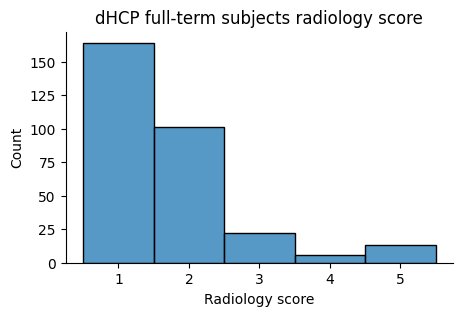

In [20]:
# fullterm subjects
dhcp_final_cn_hist = dhcp_final_cn.copy()
dhcp_final_cn_hist = dhcp_final_cn_hist.sort_values(by='radiology_score')

plt.figure(figsize=(5, 3))
sns.histplot(dhcp_final_cn_hist['radiology_score'], bins=5)
sns.despine()

plt.xlabel('Radiology score')
plt.ylabel('Count')
plt.title('dHCP full-term subjects radiology score')
plt.show()


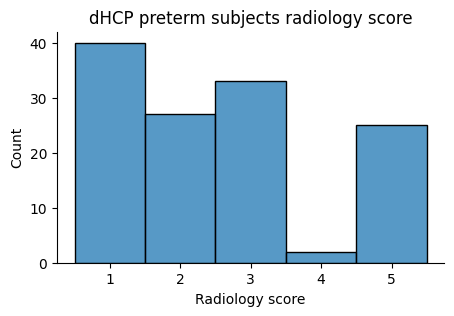

In [21]:
# preterm subjects
dhcp_final_pt_hist = dhcp_final_pt.copy()
dhcp_final_pt_hist = dhcp_final_pt_hist.sort_values(by='radiology_score')

plt.figure(figsize=(5, 3))
sns.histplot(dhcp_final_pt_hist['radiology_score'], bins=5)
sns.despine()

plt.xlabel('Radiology score')
plt.ylabel('Count')
plt.title('dHCP preterm subjects radiology score')
plt.show()